In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


### Load the packages

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
%matplotlib inline

### Load the data

In [4]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [6]:
df.shape

(7043, 21)

### Data Analysis & Preparation

**Encoding target var: Churn**

In [7]:
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df.Churn.mean()

0.2653698707936959

**Create TotalCharges**

In [8]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)

In [9]:
df = df.dropna()

**Create Continuous Vars**

In [10]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


**Normalize the variable**

In [11]:
df['MonthlyCharges'] = np.log(df['MonthlyCharges'])
df['MonthlyCharges'] = (df['MonthlyCharges'] - df['MonthlyCharges'].mean())/df['MonthlyCharges'].std()

df['TotalCharges'] = np.log(df['TotalCharges'])
df['TotalCharges'] = (df['TotalCharges'] - df['TotalCharges'].mean())/df['TotalCharges'].std()

df['tenure'] = (df['tenure'] - df['tenure'].mean())/df['tenure'].std()

In [12]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7.032000e+03,7.032000e+03,7.032000e+03
mean,-1.028756e-16,4.688495e-14,7.150708e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.280157e+00,-1.882268e+00,-2.579056e+00
25%,-9.542285e-01,-7.583727e-01,-6.080585e-01
50%,-1.394072e-01,3.885103e-01,1.950521e-01
75%,9.198605e-01,8.004829e-01,8.382338e-01
max,1.612459e+00,1.269576e+00,1.371323e+00


In [13]:
continuous_vars = list(df.describe().columns)
continuous_vars

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

**One-Hot Encoding**

In [14]:
for col in list(df.columns):
    print(col, df[col].nunique())

customerID 7032
gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 72
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1584
TotalCharges 6530
Churn 2


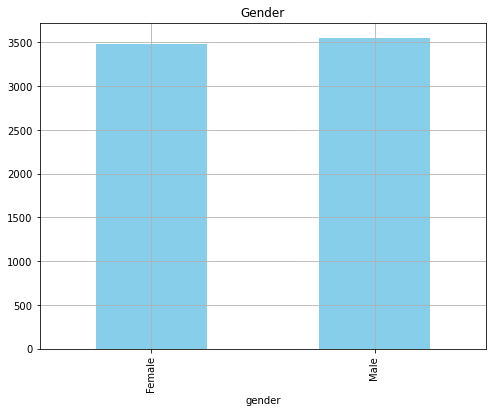

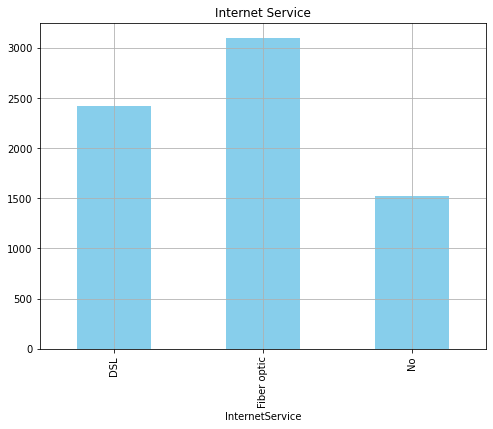

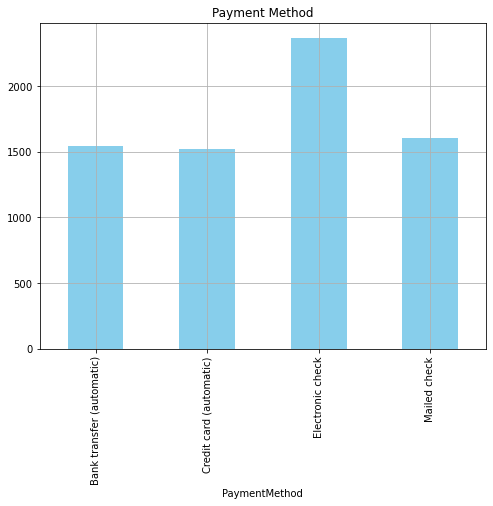

In [15]:
df.groupby('gender').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Gender'
)
plt.show()

df.groupby('InternetService').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Internet Service'
)
plt.show()

df.groupby('PaymentMethod').count()['customerID'].plot(
    kind='bar', color='skyblue', grid=True, figsize=(8,6), title='Payment Method'
)
plt.show()

In [16]:
dummy_cols = []

sample_set = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].copy(deep=True)

for col in list(df.columns):
    if col not in ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'] and df[col].nunique() < 5:
        dummy_vars = pd.get_dummies(df[col])
        dummy_vars.columns = [col+str(x) for x in dummy_vars.columns]        
        sample_set = pd.concat([sample_set, dummy_vars], axis=1)

In [17]:
sample_set.head()

,tenure,MonthlyCharges,TotalCharges,Churn,genderFemale,genderMale,SeniorCitizen0,SeniorCitizen1,PartnerNo,PartnerYes,...,StreamingMoviesYes,ContractMonth-to-month,ContractOne year,ContractTwo year,PaperlessBillingNo,PaperlessBillingYes,PaymentMethodBank transfer (automatic),PaymentMethodCredit card (automatic),PaymentMethodElectronic check,PaymentMethodMailed check
0,-1.280157,-1.054244,-2.281382,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0.064298,0.032896,0.389269,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,-1.239416,-0.061298,-1.452520,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0.512450,-0.467578,0.372439,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,-1.239416,0.396862,-1.234860,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [18]:
list(sample_set.columns)

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'genderFemale',
 'genderMale',
 'SeniorCitizen0',
 'SeniorCitizen1',
 'PartnerNo',
 'PartnerYes',
 'DependentsNo',
 'DependentsYes',
 'PhoneServiceNo',
 'PhoneServiceYes',
 'MultipleLinesNo',
 'MultipleLinesNo phone service',
 'MultipleLinesYes',
 'InternetServiceDSL',
 'InternetServiceFiber optic',
 'InternetServiceNo',
 'OnlineSecurityNo',
 'OnlineSecurityNo internet service',
 'OnlineSecurityYes',
 'OnlineBackupNo',
 'OnlineBackupNo internet service',
 'OnlineBackupYes',
 'DeviceProtectionNo',
 'DeviceProtectionNo internet service',
 'DeviceProtectionYes',
 'TechSupportNo',
 'TechSupportNo internet service',
 'TechSupportYes',
 'StreamingTVNo',
 'StreamingTVNo internet service',
 'StreamingTVYes',
 'StreamingMoviesNo',
 'StreamingMoviesNo internet service',
 'StreamingMoviesYes',
 'ContractMonth-to-month',
 'ContractOne year',
 'ContractTwo year',
 'PaperlessBillingNo',
 'PaperlessBillingYes',
 'PaymentMethodBank transfer (au

### Train & Test Sets

In [21]:
target_var = 'Churn'
features = [x for x in list(sample_set.columns) if x != target_var]

In [22]:
model = Sequential()
model.add(Dense(16, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

第一层是输入层，其中input_dim仅是样本集中的列数，而输出单元数是16。我们在此输入层使用relu激活功能。然后，在隐藏层中，输出单元的数量为8，并且要使用的激活功能为relu。最后，输出层有一个输出单位，这是客户流失的可能性，我们在这一层中使用Sigmoid激活函数

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    sample_set[features], 
    sample_set[target_var], 
    test_size=0.3
)

In [29]:
model.fit(X_train, y_train, epochs=50, batch_size=100)

Epoch 1/50
4922/4922 [==============================] - 0s 73us/step - loss: 0.6871 - accuracy: 0.5638
Epoch 2/50
4922/4922 [==============================] - 0s 13us/step - loss: 0.5409 - accuracy: 0.7314
Epoch 3/50
4922/4922 [==============================] - 0s 13us/step - loss: 0.5034 - accuracy: 0.7322
Epoch 4/50
4922/4922 [==============================] - 0s 13us/step - loss: 0.4717 - accuracy: 0.7452
Epoch 5/50
4922/4922 [==============================] - 0s 13us/step - loss: 0.4404 - accuracy: 0.7926
Epoch 6/50
4922/4922 [==============================] - 0s 13us/step - loss: 0.4225 - accuracy: 0.8037
Epoch 7/50
4922/4922 [==============================] - 0s 13us/step - loss: 0.4150 - accuracy: 0.8066
Epoch 8/50
4922/4922 [==============================] - 0s 13us/step - loss: 0.4113 - accuracy: 0.8070
Epoch 9/50
4922/4922 [==============================] - 0s 14us/step - loss: 0.4083 - accuracy: 0.8098
Epoch 10/50
4922/4922 [==============================] - 0s 13us/step - l

**Accuracy, Precision, Recall**

In [30]:
in_sample_preds = [round(x[0]) for x in model.predict(X_train)]
out_sample_preds = [round(x[0]) for x in model.predict(X_test)]

In [31]:
print('In-Sample Accuracy: %0.4f' % accuracy_score(y_train, in_sample_preds))
print('Out-of-Sample Accuracy: %0.4f' % accuracy_score(y_test, out_sample_preds))

print('\n')

print('In-Sample Precision: %0.4f' % precision_score(y_train, in_sample_preds))
print('Out-of-Sample Precision: %0.4f' % precision_score(y_test, out_sample_preds))

print('\n')

print('In-Sample Recall: %0.4f' % recall_score(y_train, in_sample_preds))
print('Out-of-Sample Recall: %0.4f' % recall_score(y_test, out_sample_preds))

In-Sample Accuracy: 0.8171
Out-of-Sample Accuracy: 0.7991


In-Sample Precision: 0.6946
Out-of-Sample Precision: 0.6440


In-Sample Recall: 0.5660
Out-of-Sample Recall: 0.5154


**ROC & AUC**

In [32]:
in_sample_preds = [x[0] for x in model.predict(X_train)]
out_sample_preds = [x[0] for x in model.predict(X_test)]
in_sample_fpr, in_sample_tpr, in_sample_thresholds = roc_curve(y_train, in_sample_preds)
out_sample_fpr, out_sample_tpr, out_sample_thresholds = roc_curve(y_test, out_sample_preds)

In [33]:
in_sample_roc_auc = auc(in_sample_fpr, in_sample_tpr)
out_sample_roc_auc = auc(out_sample_fpr, out_sample_tpr)

print('In-Sample AUC: %0.4f' % in_sample_roc_auc)
print('Out-Sample AUC: %0.4f' % out_sample_roc_auc)

In-Sample AUC: 0.8691
Out-Sample AUC: 0.8314


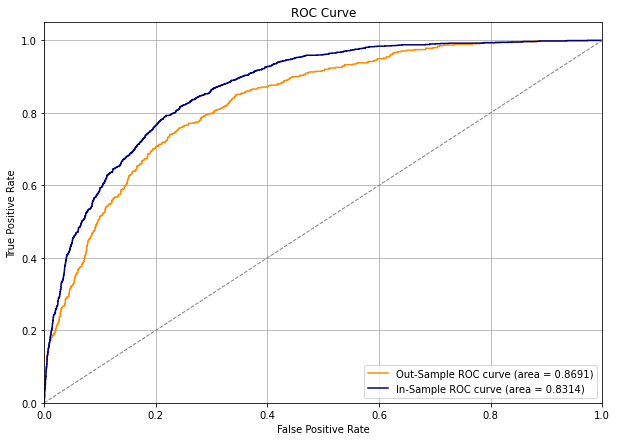

In [34]:
plt.figure(figsize=(10,7))

plt.plot(
    out_sample_fpr, out_sample_tpr, color='darkorange', label='Out-Sample ROC curve (area = %0.4f)' % in_sample_roc_auc
)
plt.plot(
    in_sample_fpr, in_sample_tpr, color='navy', label='In-Sample ROC curve (area = %0.4f)' % out_sample_roc_auc
)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()


EOD